## Setup

In [1]:
from environment import CollisionChecker, construct_benchmark_environments
from planners.IPBasicPRM import BasicPRM
import pprint
import networkx as nx

## Load Environments

In [2]:
env_dict = construct_benchmark_environments()

## Create Planner and Collision Checker for each environment

In [3]:
for name, item in env_dict.items():
    cc = CollisionChecker(item["env"])
    planner = BasicPRM(cc)
    # Inject Graph
    G = nx.Graph()

    node_names = []

    for i, coord in enumerate(item["smooth_path"]):
        # Determine the name based on position in the list
        if i == 0:
            n = "start"
        elif i == len(item["smooth_path"]) - 1:
            n = "goal"
        else:
            n = f"{i}" # Naming middle nodes generically
        
        node_names.append(n)
        
        # Add node with the 'pos' attribute
        G.add_node(n, pos=coord)

    # Add edges connecting each node to the next
    for i in range(len(node_names) - 1):
        current_node = node_names[i]
        next_node = node_names[i+1]
        G.add_edge(current_node, next_node)

    planner.graph = G
    
    env_dict[name]["planner"] = planner



## Show the Environments

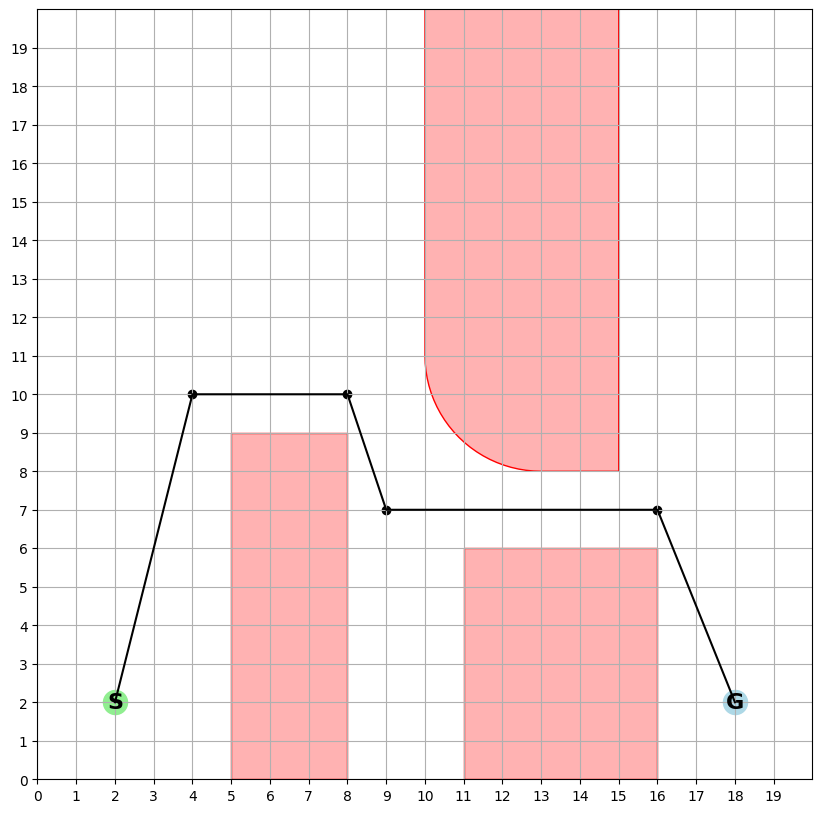

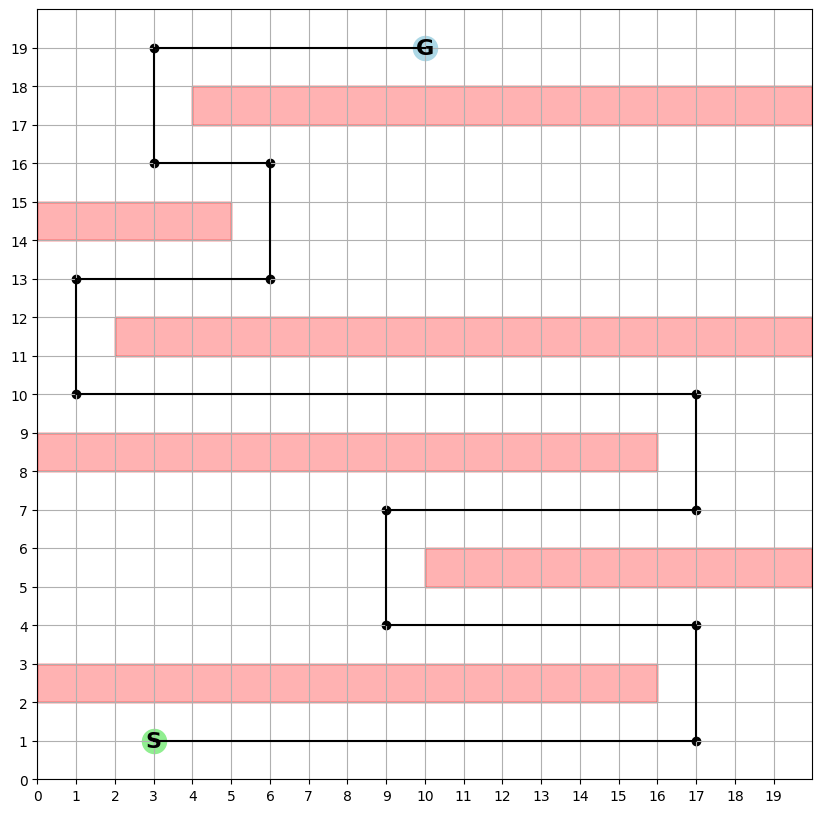

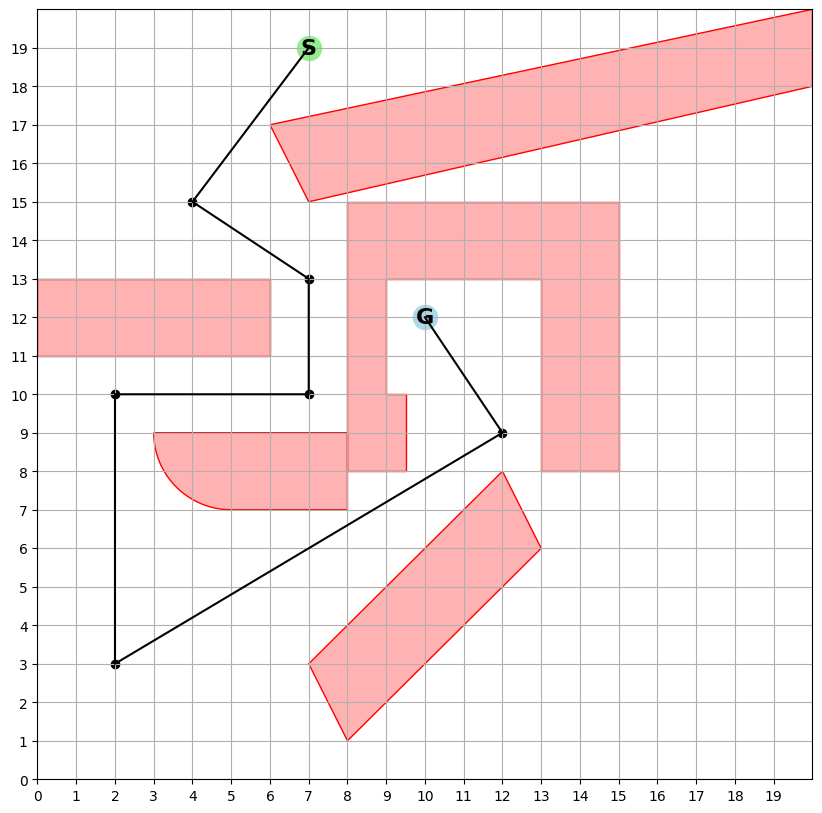

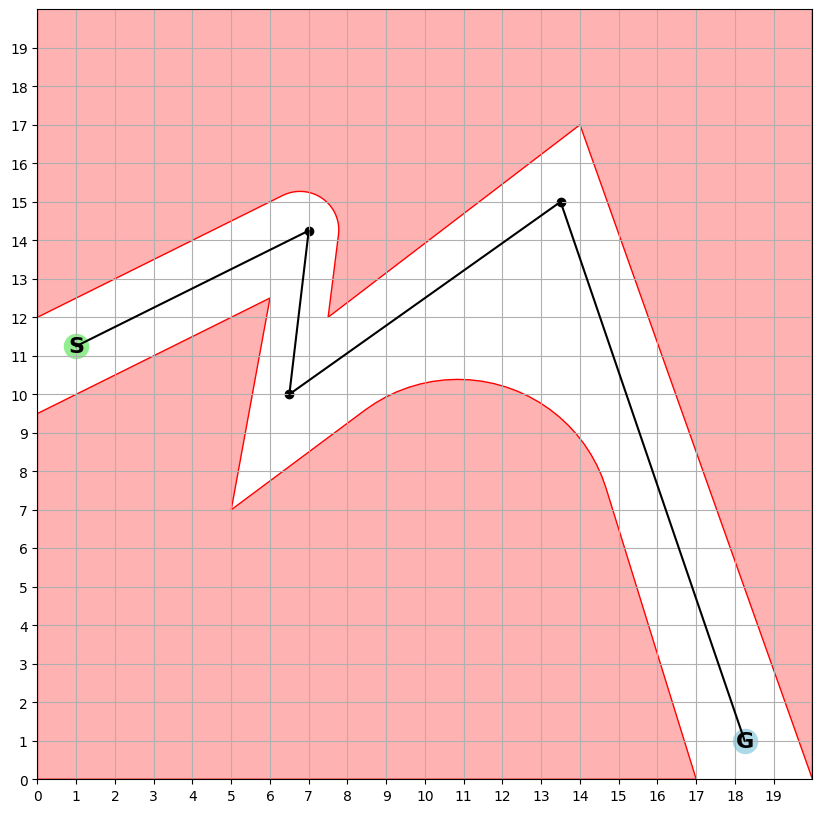

In [7]:
for name, item in env_dict.items():
    ax = item["planner"]._collisionChecker.draw_enviroments()
    item["planner"]._collisionChecker.draw_path(item["smooth_path"], ax=ax)
